<a href="https://colab.research.google.com/github/cs20m016/cs6910-Assignment-3/blob/main/RNNvanila.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!unzip /content/drive/MyDrive/lexicons.zip > /dev/null

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import random
from keras.utils.vis_utils import plot_model

In [5]:
# Path to the data txt file on disk.
data_path = "/content/lexicons/hi.translit.sampled.train.tsv"
val_path = "/content/lexicons/hi.translit.sampled.dev.tsv"
test_path = "/content/lexicons/hi.translit.sampled.test.tsv"

In [6]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: len(lines) - 1]:
    target_text, input_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters.add(" ")
target_characters.add(" ")
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [7]:
val_input_texts = []
val_target_texts = []

with open(val_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: len(lines) - 1]:
    target_text, input_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    val_input_texts.append(input_text)
    val_target_texts.append(target_text)

In [8]:
test_input_texts = []
test_target_texts = []

with open(test_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: len(lines) - 1]:
    target_text, input_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    test_input_texts.append(input_text)
    test_target_texts.append(target_text)

In [9]:
print("Number of samples:", len(input_texts))
print("Number of validation samples:", len(val_input_texts))
print("Number of test samples:", len(test_input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 44204
Number of validation samples: 4358
Number of test samples: 4502
Number of unique input tokens: 27
Number of unique output tokens: 66
Max sequence length for inputs: 20
Max sequence length for outputs: 21


In [10]:
#Train Set
for i in range (5):
  index = random. randint(0,len(target_texts))
  print(input_texts[index],target_texts[index])

mazdoori 	मजदूरी

shatranj 	शतरंज

tote 	तोते

ecg 	ईसीजी

sixers 	सिक्सर्स



In [11]:
#Validation Set
for i in range (5):
  index = random. randint(0,len(val_target_texts))
  print(val_input_texts[index],val_target_texts[index])

junshaan 	जुनशान

kagazon 	कागज़ों

pine 	पीने

solahaven 	सोलहवें

prakshepit 	प्रक्षेपित



In [12]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [13]:
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
print(np.shape(encoder_input_data),np.shape(decoder_input_data),np.shape(decoder_target_data))

(44204, 20, 27) (44204, 21, 66) (44204, 21, 66)


In [14]:
val_encoder_input_data = np.zeros((len(val_input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
val_decoder_input_data = np.zeros((len(val_input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
val_decoder_target_data = np.zeros((len(val_input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
print(np.shape(val_encoder_input_data),np.shape(val_decoder_input_data),np.shape(val_decoder_target_data))

(4358, 20, 27) (4358, 21, 66) (4358, 21, 66)


In [15]:
test_encoder_input_data = np.zeros((len(test_input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
print(np.shape(test_encoder_input_data))

(4502, 20, 27)


In [16]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [17]:
for i, (val_input_text, val_target_text) in enumerate(zip(val_input_texts, val_target_texts)):
    for t, char in enumerate(val_input_text):
        val_encoder_input_data[i, t, input_token_index[char]] = 1.0
    val_encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(val_target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        val_decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            val_decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    val_decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    val_decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [18]:
for i, (test_input_text, ) in enumerate(zip(test_input_texts, )):
    for t, char in enumerate(test_input_text):
        test_encoder_input_data[i, t, input_token_index[char]] = 1.0
    test_encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

In [87]:
batch_size = 64  # Batch size for training.
epochs = 10  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
dropout=0.0
recc_dropout=0.0

In [88]:
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.SimpleRNN(latent_dim, return_state=True,dropout=dropout,recurrent_dropout=recc_dropout)
encoder_outputs, state_h = encoder(encoder_inputs)

decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))
decoder_rnn = keras.layers.SimpleRNN(latent_dim, return_sequences=True,return_state=True,dropout=dropout,recurrent_dropout=recc_dropout)
decoder_outputs,_ = decoder_rnn(decoder_inputs, initial_state=state_h)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [89]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs, validation_data=([val_encoder_input_data, val_decoder_input_data],val_decoder_target_data))

Epoch 1/10
691/691 [==============================] - 20s 27ms/step - loss: 1.1400 - accuracy: 0.7305 - val_loss: 0.5379 - val_accuracy: 0.8496
Epoch 2/10
691/691 [==============================] - 18s 26ms/step - loss: 0.5058 - accuracy: 0.8556 - val_loss: 0.4667 - val_accuracy: 0.8649
Epoch 3/10
691/691 [==============================] - 18s 26ms/step - loss: 0.4235 - accuracy: 0.8744 - val_loss: 0.4171 - val_accuracy: 0.8792
Epoch 4/10
691/691 [==============================] - 18s 27ms/step - loss: 0.3767 - accuracy: 0.8863 - val_loss: 0.3928 - val_accuracy: 0.8828
Epoch 5/10
691/691 [==============================] - 19s 27ms/step - loss: 0.3503 - accuracy: 0.8934 - val_loss: 0.3822 - val_accuracy: 0.8872
Epoch 6/10
691/691 [==============================] - 18s 26ms/step - loss: 0.3293 - accuracy: 0.8984 - val_loss: 0.3631 - val_accuracy: 0.8912
Epoch 7/10
691/691 [==============================] - 18s 26ms/step - loss: 0.3115 - accuracy: 0.9034 - val_loss: 0.3584 - val_accuracy:

In [90]:
# Save model
model.save("s2s")

INFO:tensorflow:Assets written to: s2s/assets


In [91]:
l_model = keras.models.load_model("s2s")

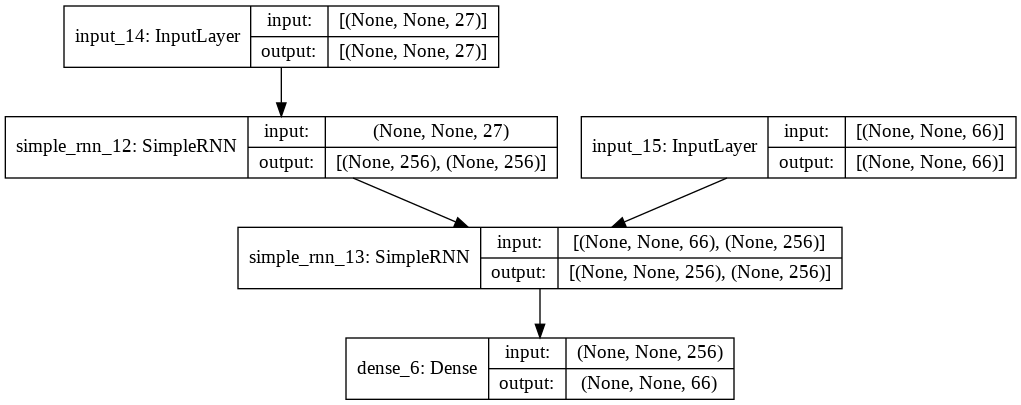

In [92]:
plot_model(l_model, show_shapes=True)

In [93]:
last_il = int(l_model.input[1].name[-1])
next_1 = "input_"+str(last_il+1)
next_2 = "input_"+str(last_il+2)
print(next_1,next_2)

input_6 input_7


In [94]:
# Define sampling models GRU
# Restore the model and construct the encoder and decoder.
encoder_inputs = l_model.input[0]  # input_1
encoder_outputs, state_h_enc = l_model.layers[2].output  # gru_1
encoder_model = keras.Model(encoder_inputs, state_h_enc)

decoder_inputs = l_model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name=next_1)
decoder_rnn = l_model.layers[3]
decoder_outputs, state_h_dec = decoder_rnn(decoder_inputs, initial_state=decoder_state_input_h)
decoder_dense = l_model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model([decoder_inputs] + [decoder_state_input_h], [decoder_outputs] + [state_h_dec])

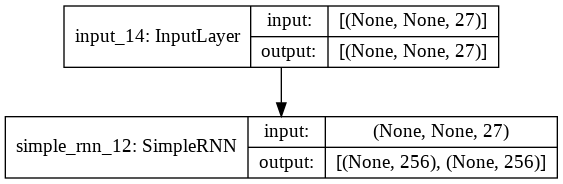

In [95]:
plot_model(encoder_model, show_shapes=True)

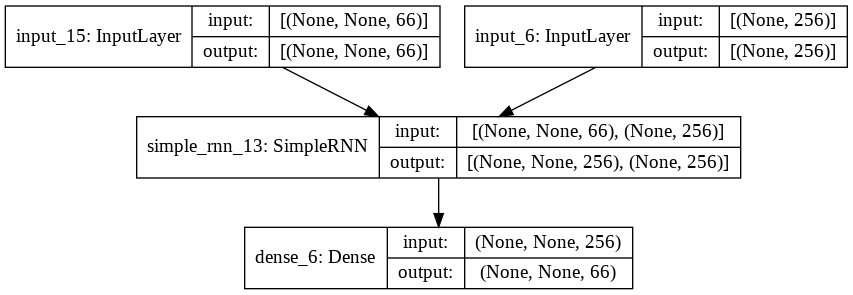

In [96]:
plot_model(decoder_model, show_shapes=True)

In [98]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [99]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq] + [states_value])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = h
    return decoded_sentence

In [101]:
valid = 0
for i in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    #seq_index=random.randint(0,len(test_input_texts))
    seq_index=i
    input_seq = test_encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    #print("-")
    #print("Input sentence:", test_input_texts[seq_index])
    #print("Decoded sentence:", decoded_sentence)
    #print("Actual sentence:", test_target_texts[seq_index])
    flag=1
    for (i,j) in zip(decoded_sentence,test_target_texts[seq_index]):
      if i!=j:
        flag=0
        break
    if flag==1:
      valid += 1
print(valid/len(test_input_texts))
#print(valid)

0.14260328742780987
